In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from scipy.fft import fft
import os
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2
from models.newton_ode import mse, initialize_params, batch_forward_pass, get_loss_function, train, forward_pass
from tqdm import tqdm
from functools import partial

from utils import Shuffler


/home/felipeangelim/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [48]:
def append_derivatives_to_dataframe(df, col, dt, **kwargs):
    df[col + "_dot"] = (df[col] - df[col].shift())/dt
    return df

def get_data(freq, polyorder=3, window_length=151):
    
    all_data = pd.DataFrame()
    for file in filter(lambda x: ("_"+str(freq)+"Hz" in x) and x.endswith(".txt"), os.listdir("amb_sin/")):
        print(file)
        df = load_amb_sin_data("amb_sin/" + file).iloc[10000:]
        df["f_ay"] -= df["f_ay"].mean()
        df["f_ax"] -= df["f_ax"].mean()
        df["f_bx"] -= df["f_bx"].mean()
        df["f_by"] -= df["f_by"].mean()
        df["x"] = (df["ax"] + df["bx"])/2
        #df["x"] = df["ax"]
        df["y"] = (df["ay"] + df["by"])/2
        #df["y"] = df["ay"]
        df['fx'] = df["f_ax"] + df["f_bx"]
        #df["fx"] = df["f_ax"]
        df['fy'] = df["f_ay"] + df["f_by"]
        #df["fx"] = df["f_ay"]
        df = df[["datetime", "x", "y", "fx", "fy"]]
        
        def to_ms(t):
            try:
                return t.delta*1e-9
            except:
                return np.nan
        
        #df["dt"] = df["dt"].cumsum()
        
        
        mean_dt = (df["datetime"] - df["datetime"].shift()).median().delta*1e-9
        for col in ["x", "y"]:
            df = append_derivative_to_dataframe(df, col, dt=mean_dt, window_length=window_length, polyorder=polyorder)

        df = append_derivative_to_dataframe(df, "fx", dt=mean_dt, window_length=window_length, polyorder=polyorder)
        df = append_derivative_to_dataframe(df, "fy", dt=mean_dt, window_length=window_length, polyorder=polyorder)
        df = df.iloc[1:]
        
        df["dt"] = df["datetime"] - df.iloc[0, 0]
        df["dt"] = df["dt"].apply(to_ms)
        
        all_data = pd.concat([all_data, df], ignore_index=True)
    
    return all_data

def get_vectors_from_data(df):
    q = np.expand_dims(df[['x', 'y']].values, axis=-1)
    q_dot = np.expand_dims(df[['x_dot', 'y_dot']].values, axis=-1)
    #q_dot2 = np.expand_dims(df[['x_dot2', 'y_dot2']].values, axis=-1)
    f = np.expand_dims(df[['fx', 'fy']].values, axis=-1)
    t = df["dt"].values
    return q, q_dot,[], f, t


freq = 49
polyorder = 1
window_length = 7
df = get_data(freq=freq, polyorder=polyorder, window_length=window_length)

sine_fx_49Hz_0RPM.txt
sine_fy_49Hz_0RPM.txt


In [49]:
df

,datetime,x,y,fx,fy,x_dot,y_dot,fx_dot,fy_dot,dt
0,2019-03-24 00:24:06.139077,0.000044,-2.679340e-07,-2.825807,0.308104,-0.011186,-0.000308,560.167046,86.064963,0.000000
1,2019-03-24 00:24:06.139272,0.000042,-1.734290e-07,-2.616875,-0.236785,-0.011186,-0.000308,560.167046,86.064963,0.000195
2,2019-03-24 00:24:06.139468,0.000039,-3.695100e-07,-2.810533,-0.580254,-0.011186,-0.000308,560.167046,86.064963,0.000391
3,2019-03-24 00:24:06.139663,0.000037,-2.304825e-07,-2.120576,-0.244809,-0.010859,-0.000755,702.306753,-86.346777,0.000586
4,2019-03-24 00:24:06.139858,0.000035,-7.060165e-07,-2.526951,0.142555,-0.010542,-0.000895,733.964720,433.988278,0.000781
...,...,...,...,...,...,...,...,...,...,...
107993,2019-03-24 00:37:18.184780,0.000009,5.615834e-05,-0.071559,-3.256300,-0.003102,-0.001392,-36.385403,-113.864802,9.045703
107994,2019-03-24 00:37:18.184976,0.000009,5.545846e-05,-0.289058,-3.638341,-0.003651,-0.002040,-36.197830,-184.818124,9.045899
107995,2019-03-24 00:37:18.185171,0.000008,5.544186e-05,-0.262986,-2.616643,-0.003651,-0.002040,-36.197830,-184.818124,9.046094
107996,2019-03-24 00:37:18.185366,0.000007,5.488481e-05,-0.374874,-3.288302,-0.003651,-0.002040,-36.197830,-184.818124,9.046289


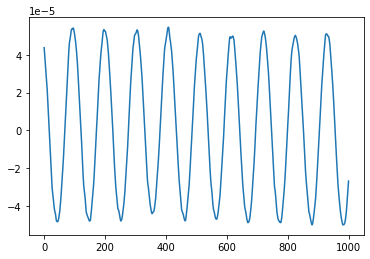

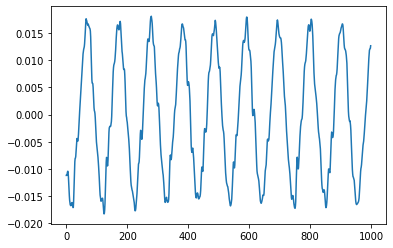

In [50]:
i = 1000
plt.plot(df.iloc[:i]["x"])
plt.show()
plt.plot(df.iloc[:i]["x_dot"])
plt.show()

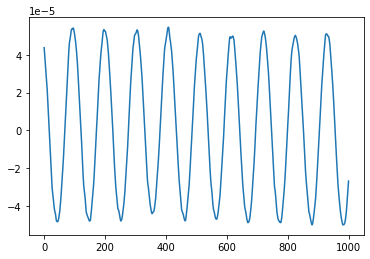

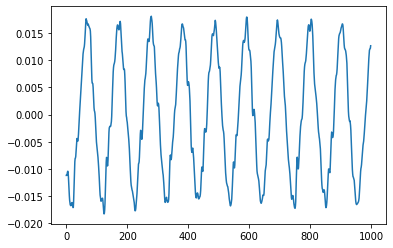

In [51]:
i = 1000
plt.plot(df.iloc[:i]["x"])
plt.show()
plt.plot(df.iloc[:i]["x_dot"])
plt.show()

In [52]:
def split_sequence(sequence, n_steps, always_future=True):
    X  = list()
    for i in range(len(sequence)):
        
        # Queremos sempre a frente de t
        if always_future:
            i += 1
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)


In [76]:
q, q_dot, q_dot2, f, t = get_vectors_from_data(df)

q *= 1e6
q_dot *= 1e6
f *= 1e6

In [77]:
n_steps = 5
q_future = split_sequence(q, n_steps)
q_dot_future = split_sequence(q_dot, n_steps)
f = split_sequence(f, n_steps, always_future=False)

q = q[:q_future.shape[0]]
q_dot = q_dot[:q_future.shape[0]]

f = f[:q_future.shape[0]]

In [78]:
f.shape

(107992, 5, 2, 1)

In [79]:
#t = np.expand_dims(t, axis=-1)

In [80]:
from jax.experimental.stax import Dense, serial
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap, value_and_grad, jacfwd, jacrev, jacobian, hessian
from jax import random
from jax.experimental import stax
from jax.experimental.ode import odeint
from jax.experimental.optimizers import adam, sgd
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt



"""

Utils

"""

def mse(y_true, y_pred):
    y_true, y_pred = jnp.squeeze(y_true), jnp.squeeze(y_pred)
    if  (y_true.shape != y_pred.shape):
        raise ValueError(f"y_true {y_true.shape} and y_pred {y_pred.shape} must have the same shape.")
    diff = (y_true - y_pred)/(10**jnp.log10(jnp.abs(y_true)))
    return jnp.mean(jnp.square(diff))

def mae(y_true, y_pred):
    y_true, y_pred = jnp.squeeze(y_true), jnp.squeeze(y_pred)
    if  (y_true.shape != y_pred.shape):
        raise ValueError(f"y_true {y_true.shape} and y_pred {y_pred.shape} must have the same shape.")
    diff = (y_true - y_pred)#*jnp.array([[1e5, 1e1]])
    return jnp.mean(jnp.abs(diff))


"""

Modelo Físico

"""


def initialize_params(rng, dims, scale=1):
    """ Inicializa massa k e c """
    keys = random.split(rng, 3)
    params = [random.normal(keys[i], [dims, dims])*scale for i in range(2)]
    return params

mass = jnp.array([[1, 0], [0, 1]])
g = jnp.array([[0], [0]])

def dynamics_fun(y, t, f, params):
    """

    :param y: inputs [position, velocity]
    :param t: time
    :param f: force
    :return: outputs dydt [velocity, acceleration]
    """

    q, q_dot = jnp.split(y.reshape((-1)), 2)

    q = q.reshape((-1, 1))
    q_dot = q_dot.reshape((-1, 1))
    M_inv = np.linalg.pinv(mass)
    C = params[1] @ q_dot
    K = params[0] @ q
    
    q_dot2 = jnp.squeeze(M_inv @ (f - C - K) - g, -1)

    dydt = jnp.concatenate([q_dot.flatten(), q_dot2.flatten()], axis=0)

    return dydt

def forward_pass(params, q, q_dot, f):
    """
    Uma instancia de x é do formato [x, x_dot]
    Um forward pass estima a aceleração do sistema

    """
    q = q.reshape((-1,))
    q_dot = q_dot.reshape((-1,))
    y =  jnp.concatenate([q, q_dot])
    
    shape = y.shape
    
    ysol = []
    for i in range(n_steps):
        y = odeint(dynamics_fun, y, jnp.linspace(0, 0.000195, num=10), f[i], params)[-1]
        y = y.reshape(shape)        
        ysol.append(jnp.expand_dims(y, axis=0))
    ysol = jnp.concatenate(ysol, axis=0)

    q_sol, q_dot_sol = ysol.transpose().split(2)
    q_sol = q_sol.transpose().reshape((-1, 2, 1))
    q_dot_sol = q_dot_sol.transpose().reshape((-1, 2,  1))
    
    return q_sol, q_dot_sol
#forward_pass = partial(_forward_pass, n_steps=n_steps)

batch_forward_pass = vmap(forward_pass, in_axes=(None, 0, 0, 0), out_axes=0)


rng = random.PRNGKey(15)
params = initialize_params(rng, dims=2, scale=1)

i = 0
q_pred, q_dot_pred = forward_pass(params, q[i], q_dot[i], f[i])

print(mse(y_pred=q_pred, y_true=q_future[i]))
print(mse(y_pred=q_dot_pred, y_true=q_dot_future[i]))

print(mae(y_pred=q_pred, y_true=q_future[i]))
print(mae(y_pred=q_dot_pred, y_true=q_dot_future[i]))

0.1665465
0.11853425
0.34097496
1126.9922


In [81]:

def _mse(params, q, q_dot, f, q_future):
    q_pred, q_dot_pred = forward_pass(params, q, q_dot, f)
    y_true = q_future
    y_pred = q_pred
    
    y_true, y_pred = jnp.squeeze(y_true), jnp.squeeze(y_pred)
    if  (y_true.shape != y_pred.shape):
        raise ValueError(f"y_true {y_true.shape} and y_pred {y_pred.shape} must have the same shape.")
    diff = (y_true - y_pred)
    return jnp.mean(jnp.square(diff))
    
#grad(_mse)(params, q[i], q_dot[i], f[i], q_future[i])

In [82]:
res = batch_forward_pass(params, q, q_dot, f)

In [83]:
@jit
def loss(params, q, q_dot, f, q_future, q_dot_future):
    q_pred, q_dot_pred = batch_forward_pass(params, q, q_dot, f)
    return mae(y_true=q_future, y_pred=q_pred)# + mae(y_true=q_dot_future, y_pred=q_dot_pred)

In [84]:
#grad(loss)(params, q[100:130], q_dot[100:130], f[100:130], q_future[100:130], q_dot_future[100:130])

In [86]:

def train_step(q, q_dot, f, q_future, q_dot_future , opt_state, opt_update, get_params, loss):
    params = get_params(opt_state)
    mse, grad = value_and_grad(loss)(params,  q, q_dot, f, q_future, q_dot_future)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state, mse


def train(params,  q, q_dot, f, q_future, q_dot_future,  batch_size, optimizer, step_size,  epochs=1, callback=None):

    init_fun, opt_update, get_params = optimizer(step_size=step_size)
    opt_state = init_fun(params)

    epoch_errors = []
    params_history = []
    for epoch in range(epochs):

        n_batchs = len(q)//batch_size
        errors = []


        print("Epoch", epoch)
        for i in tqdm(range(n_batchs)):
            q_batch      = jnp.array(q[i*batch_size:((i+1)*batch_size)])
            q_dot_batch  = jnp.array(q_dot[i*batch_size:((i+1)*batch_size)])
            f_batch = jnp.array(f[i*batch_size:((i+1)*batch_size)])
            
            q_future_batch = jnp.array(q_future[i*batch_size:((i+1)*batch_size)])
            q_dot_future_batch = jnp.array(q_dot_future[i*batch_size:((i+1)*batch_size)])
            
            params, opt_state, error = train_step(q_batch, q_dot_batch, f_batch, q_future_batch, q_dot_future_batch,
                                                  opt_state, opt_update,
                                                  get_params, loss)
            errors.append(error)
            params_history.append(params.copy())

        mean_error = np.mean(np.array(errors))
        print("Epoch", epoch, ", mean error:",mean_error, "params:", params)
        epoch_errors.append(mean_error)

        if callback:
            y_pred = np.array(batch_forward_pass(params, q, q_dot, f))
            callback(y_pred=y_pred, y_true=q_future)

    return params



def callback(y_pred, y_true):

    plt.figure(figsize=(10, 8))
    random_ind = int(np.random.uniform(0, len(y_pred) - window - 1))
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred))[random_ind:(random_ind + window)], linestyle="dotted")
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_true))[random_ind:(random_ind + window)])
    plt.show()

batch_size=256

params = train(params,  q, q_dot, f, q_future, q_dot_future,  batch_size, optimizer=adam, step_size=1e1, epochs=30, callback=None)

  1%|          | 4/421 [00:00<00:14, 29.10it/s]

Epoch 0


  0%|          | 0/421 [00:00<?, ?it/s]

Epoch 0 , mean error: 0.58037835 params: [DeviceArray([[2929.6316,  832.4999],
             [2529.7139, 3883.4067]], dtype=float32), DeviceArray([[ 422.90445,  -67.87565],
             [-626.19086,  149.8125 ]], dtype=float32)]
Epoch 1


  1%|          | 3/421 [00:00<00:15, 26.50it/s]

Epoch 1 , mean error: 0.549606 params: [DeviceArray([[4637.317 , 1479.6552],
             [2924.2495, 5760.8   ]], dtype=float32), DeviceArray([[  75.48006  ,    4.4354553],
             [-267.86874  ,   80.889114 ]], dtype=float32)]
Epoch 2


  1%|          | 3/421 [00:00<00:17, 23.79it/s]

Epoch 2 , mean error: 0.5277681 params: [DeviceArray([[6014.5786, 2068.705 ],
             [2847.6404, 7048.0693]], dtype=float32), DeviceArray([[  71.253624 ,    4.9117956],
             [-235.7799   ,   75.411545 ]], dtype=float32)]
Epoch 3


  1%|          | 3/421 [00:00<00:17, 23.96it/s]

Epoch 3 , mean error: 0.5254653 params: [DeviceArray([[7233.313 , 2684.9229],
             [2741.0168, 8131.626 ]], dtype=float32), DeviceArray([[  81.21369 ,    2.397233],
             [-226.79959 ,   74.05898 ]], dtype=float32)]
Epoch 4


  1%|          | 3/421 [00:00<00:18, 22.92it/s]

Epoch 4 , mean error: 0.5240117 params: [DeviceArray([[8368.468 , 3321.4612],
             [2631.3933, 9118.084 ]], dtype=float32), DeviceArray([[  92.18005  ,   -0.5097777],
             [-221.07954  ,   72.98726  ]], dtype=float32)]
Epoch 5


  1%|          | 3/421 [00:00<00:17, 24.37it/s]

Epoch 5 , mean error: 0.5227228 params: [DeviceArray([[ 9457.646 ,  3972.597 ],
             [ 2521.4746, 10049.911 ]], dtype=float32), DeviceArray([[ 103.26831  ,   -3.0243285],
             [-217.3122   ,   72.64645  ]], dtype=float32)]
Epoch 6


  1%|          | 3/421 [00:00<00:19, 21.44it/s]

Epoch 6 , mean error: 0.5215602 params: [DeviceArray([[10517.317 ,  4628.494 ],
             [ 2408.8972, 10946.752 ]], dtype=float32), DeviceArray([[ 113.35071 ,   -5.755426],
             [-214.10728 ,   72.284485]], dtype=float32)]
Epoch 7


  1%|          | 3/421 [00:00<00:17, 24.20it/s]

Epoch 7 , mean error: 0.5204687 params: [DeviceArray([[11556.088 ,  5281.2925],
             [ 2296.9988, 11822.491 ]], dtype=float32), DeviceArray([[ 122.3156   ,   -7.9590874],
             [-211.62971  ,   71.57681  ]], dtype=float32)]
Epoch 8


  1%|          | 3/421 [00:00<00:17, 23.82it/s]

Epoch 8 , mean error: 0.51944417 params: [DeviceArray([[12583.534 ,  5926.4575],
             [ 2180.637 , 12683.1875]], dtype=float32), DeviceArray([[ 130.62927 ,  -10.130699],
             [-209.0351  ,   71.08155 ]], dtype=float32)]
Epoch 9


  1%|          | 3/421 [00:00<00:16, 24.69it/s]

Epoch 9 , mean error: 0.5184605 params: [DeviceArray([[13597.524 ,  6553.3853],
             [ 2057.6558, 13532.206 ]], dtype=float32), DeviceArray([[ 138.01111 ,  -12.220925],
             [-206.26085 ,   70.95651 ]], dtype=float32)]
Epoch 10


  1%|          | 3/421 [00:00<00:17, 24.44it/s]

Epoch 10 , mean error: 0.51754636 params: [DeviceArray([[14605.751 ,  7159.6616],
             [ 1930.0007, 14370.813 ]], dtype=float32), DeviceArray([[ 144.56229,  -13.8507 ],
             [-203.69994,   70.65797]], dtype=float32)]
Epoch 11


  1%|          | 3/421 [00:00<00:16, 24.83it/s]

Epoch 11 , mean error: 0.51666623 params: [DeviceArray([[15605.756 ,  7742.03  ],
             [ 1800.9679, 15205.678 ]], dtype=float32), DeviceArray([[ 150.1314  ,  -15.514455],
             [-201.77861 ,   69.69115 ]], dtype=float32)]
Epoch 12


  1%|          | 3/421 [00:00<00:17, 24.15it/s]

Epoch 12 , mean error: 0.5158429 params: [DeviceArray([[16596.855 ,  8298.151 ],
             [ 1672.0015, 16036.157 ]], dtype=float32), DeviceArray([[ 155.83012 ,  -17.45267 ],
             [-199.07422 ,   69.458725]], dtype=float32)]
Epoch 13


  1%|          | 3/421 [00:00<00:16, 24.83it/s]

Epoch 13 , mean error: 0.515058 params: [DeviceArray([[17583.453,  8824.574],
             [ 1541.859, 16861.207]], dtype=float32), DeviceArray([[ 160.91246 ,  -18.749449],
             [-196.60718 ,   69.363045]], dtype=float32)]
Epoch 14


  1%|          | 3/421 [00:00<00:16, 24.84it/s]

Epoch 14 , mean error: 0.5143147 params: [DeviceArray([[18565.184,  9319.33 ],
             [ 1412.332, 17681.646]], dtype=float32), DeviceArray([[ 165.67706 ,  -20.046684],
             [-194.29404 ,   68.81097 ]], dtype=float32)]
Epoch 15


  1%|          | 3/421 [00:00<00:16, 24.66it/s]

Epoch 15 , mean error: 0.5136243 params: [DeviceArray([[19540.277 ,  9778.153 ],
             [ 1279.4325, 18496.41  ]], dtype=float32), DeviceArray([[ 169.99733,  -21.40963],
             [-191.18176,   68.28957]], dtype=float32)]
Epoch 16


  1%|          | 3/421 [00:00<00:17, 24.41it/s]

Epoch 16 , mean error: 0.51295877 params: [DeviceArray([[20508.51 , 10196.648],
             [ 1143.596, 19307.008]], dtype=float32), DeviceArray([[ 173.36325 ,  -22.728706],
             [-188.7036  ,   68.280045]], dtype=float32)]
Epoch 17


  1%|          | 3/421 [00:00<00:17, 23.97it/s]

Epoch 17 , mean error: 0.5123304 params: [DeviceArray([[21471.7   , 10564.694 ],
             [ 1013.4259, 20114.139 ]], dtype=float32), DeviceArray([[ 176.89969 ,  -23.955753],
             [-186.27583 ,   67.71693 ]], dtype=float32)]
Epoch 18


  0%|          | 0/421 [00:00<?, ?it/s]

Epoch 18 , mean error: 0.5117627 params: [DeviceArray([[22424.742  , 10884.255  ],
             [  883.21344, 20914.     ]], dtype=float32), DeviceArray([[ 179.48956 ,  -25.188309],
             [-182.64238 ,   67.66065 ]], dtype=float32)]
Epoch 19


  1%|          | 3/421 [00:00<00:17, 24.02it/s]

Epoch 19 , mean error: 0.5111883 params: [DeviceArray([[23371.7  , 11153.296],
             [  754.428, 21704.31 ]], dtype=float32), DeviceArray([[ 182.20715,  -26.26842],
             [-179.12102,   67.42816]], dtype=float32)]
Epoch 20


  1%|          | 3/421 [00:00<00:17, 23.48it/s]

Epoch 20 , mean error: 0.51065475 params: [DeviceArray([[24310.82  , 11368.947 ],
             [  629.6198, 22490.16  ]], dtype=float32), DeviceArray([[ 183.99059 ,  -26.932507],
             [-176.3001  ,   67.51406 ]], dtype=float32)]
Epoch 21


  1%|          | 3/421 [00:00<00:17, 24.44it/s]

Epoch 21 , mean error: 0.51017666 params: [DeviceArray([[25243.775  , 11522.686  ],
             [  508.44885, 23267.996  ]], dtype=float32), DeviceArray([[ 185.75066 ,  -27.850655],
             [-173.12859 ,   67.3852  ]], dtype=float32)]
Epoch 22


  1%|          | 3/421 [00:00<00:17, 23.23it/s]

Epoch 22 , mean error: 0.5097157 params: [DeviceArray([[26163.348  , 11621.172  ],
             [  389.69632, 24037.043  ]], dtype=float32), DeviceArray([[ 187.0594  ,  -28.872156],
             [-169.95222 ,   66.789055]], dtype=float32)]
Epoch 23


  0%|          | 0/421 [00:00<?, ?it/s]

Epoch 23 , mean error: 0.5092945 params: [DeviceArray([[27075.83   , 11670.017  ],
             [  269.60318, 24793.725  ]], dtype=float32), DeviceArray([[ 187.90306 ,  -29.394567],
             [-166.42166 ,   66.56818 ]], dtype=float32)]
Epoch 24


  1%|          | 3/421 [00:00<00:17, 23.47it/s]

Epoch 24 , mean error: 0.50889033 params: [DeviceArray([[27978.637 , 11672.6   ],
             [  144.3098, 25538.87  ]], dtype=float32), DeviceArray([[ 188.32632 ,  -29.942316],
             [-163.44063 ,   66.33466 ]], dtype=float32)]
Epoch 25


  1%|          | 3/421 [00:00<00:17, 24.06it/s]

Epoch 25 , mean error: 0.5085116 params: [DeviceArray([[2.8872523e+04, 1.1637071e+04],
             [2.0627478e+01, 2.6272654e+04]], dtype=float32), DeviceArray([[ 188.95222,  -30.57956],
             [-160.36913,   65.9361 ]], dtype=float32)]
Epoch 26


  1%|          | 3/421 [00:00<00:17, 23.34it/s]

Epoch 26 , mean error: 0.50817144 params: [DeviceArray([[29753.037   , 11563.146   ],
             [ -102.902504, 26987.812   ]], dtype=float32), DeviceArray([[ 188.90509 ,  -31.417763],
             [-156.78682 ,   65.781235]], dtype=float32)]
Epoch 27


  1%|          | 3/421 [00:00<00:17, 24.09it/s]

Epoch 27 , mean error: 0.5078325 params: [DeviceArray([[30615.842  , 11461.699  ],
             [ -213.28572, 27688.576  ]], dtype=float32), DeviceArray([[ 189.02328,  -32.03604],
             [-154.01897,   65.31853]], dtype=float32)]
Epoch 28


  1%|          | 3/421 [00:00<00:17, 23.30it/s]

Epoch 28 , mean error: 0.5075569 params: [DeviceArray([[31466.71   , 11336.213  ],
             [ -327.70044, 28368.213  ]], dtype=float32), DeviceArray([[ 188.79855 ,  -32.449997],
             [-150.47433 ,   64.3859  ]], dtype=float32)]
Epoch 29


100%|██████████| 421/421 [00:24<00:00, 17.39it/s]


Epoch 29 , mean error: 0.5072872 params: [DeviceArray([[32299.186  , 11195.225  ],
             [ -440.43936, 29022.25   ]], dtype=float32), DeviceArray([[ 188.40971 ,  -32.87325 ],
             [-147.1145  ,   63.774284]], dtype=float32)]


In [ ]:
res[0].shape

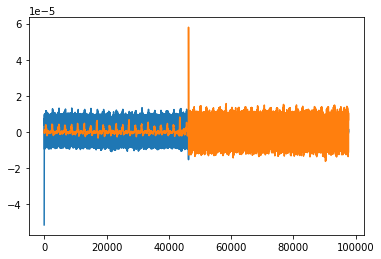

In [401]:
plt.plot(jnp.squeeze(res[0][: 1201]))